In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
ba=pd.read_csv("BA(2).csv")  
ba["Date"]=ba["Date"].astype('datetime64[ns]') # Convert column to date format
ba.columns=["date","ba_price"]
ba.head()

,date,ba_price
0,2000-03-04,37.1875
1,2000-04-04,37.3125
2,2000-05-04,36.0625
3,2000-06-04,36.1250
4,2000-07-04,35.6875


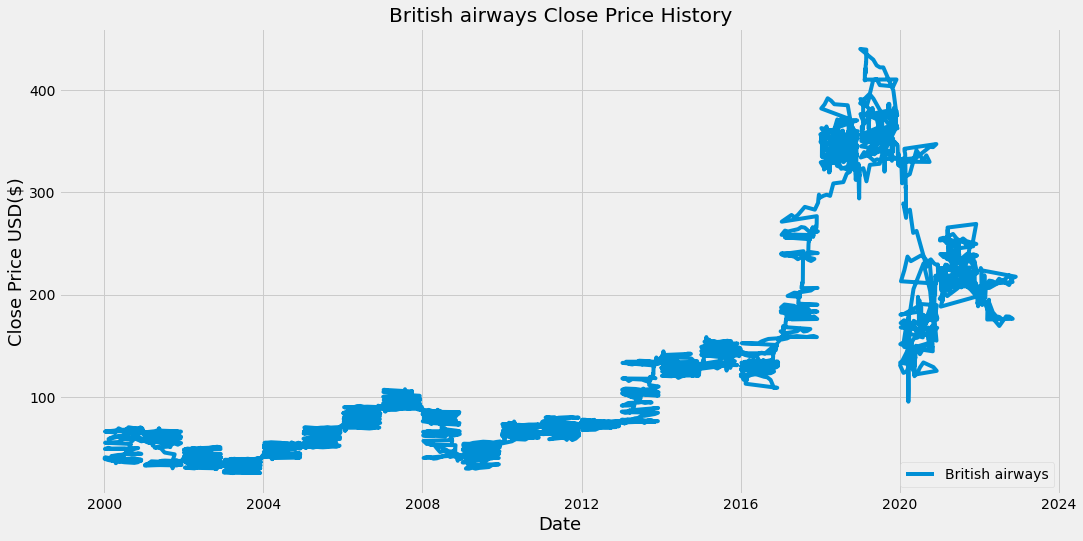

In [4]:
plt.figure(figsize=(16,8))
plt.title('British airways Close Price History')
plt.plot(ba[['date','ba_price']].set_index('date'))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.legend(['British airways'], loc='lower right')

In [5]:
# Loop to read all share price files and transform data
shares=["BrentOilPrices","BP"]


all_data=pd.DataFrame() # here we will store all the data from all shares and oil price in a master dataframe
for index in range(len(shares)):
    stock=pd.DataFrame()

# 1.- Read files
    stock=pd.read_csv(shares[index]+".csv")     
    stock.columns=["Date","Close"]
# 2.- Transform data
    stock=stock[["Date","Close"]]       
    stock["Date"]=stock["Date"].astype('datetime64[ns]')
    stock.columns=["date","share_price"]
    test=pd.DataFrame(ba) # VLOOKUP equivalent in Python to merge 2 sets of data
    output=stock.merge(test,on="date",how="left")
    stock["ba_price"]=output["ba_price"]
    stock['share_price']=pd.to_numeric(stock['share_price'], errors='coerce').dropna(0)
    stock['ba_price']=pd.to_numeric(stock['ba_price'], errors='coerce').dropna(0)
    stock["year"]=pd.to_datetime(stock["date"]).dt.year # Create a column with the year to filter later
    stock["name"]=shares[index]
    stock = stock.dropna() # get rid of all the NAN rows.
# 3.- Feature Engineering. Create new column with scaled share price from 0 to 1.
#     This will help us comparing companies later on.
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler()
    stock["share_price_scaled"]=scaler.fit_transform(stock["share_price"].to_frame())
# 4.- Append data to a master dataframe
    all_data=all_data.append(stock) #append data to one matrix
    
all_data.head(-5)

,date,share_price,ba_price,year,name,share_price_scaled
3201,2000-01-05,23.720000,39.062500,2000,BrentOilPrices,0.108285
3202,2000-01-06,23.550000,40.250000,2000,BrentOilPrices,0.107024
3205,2000-01-11,23.930000,65.750000,2000,BrentOilPrices,0.109842
3206,2000-01-12,24.620000,65.812500,2000,BrentOilPrices,0.114960
3225,2000-02-08,27.610000,49.875000,2000,BrentOilPrices,0.137136
...,...,...,...,...,...,...
8477,2021-01-07,23.910000,239.729996,2021,BP,0.139043
8479,2021-01-11,24.379999,214.580002,2021,BP,0.146296
8480,2021-01-12,25.010000,188.190002,2021,BP,0.156019
8481,2021-01-13,24.780001,207.210007,2021,BP,0.152469


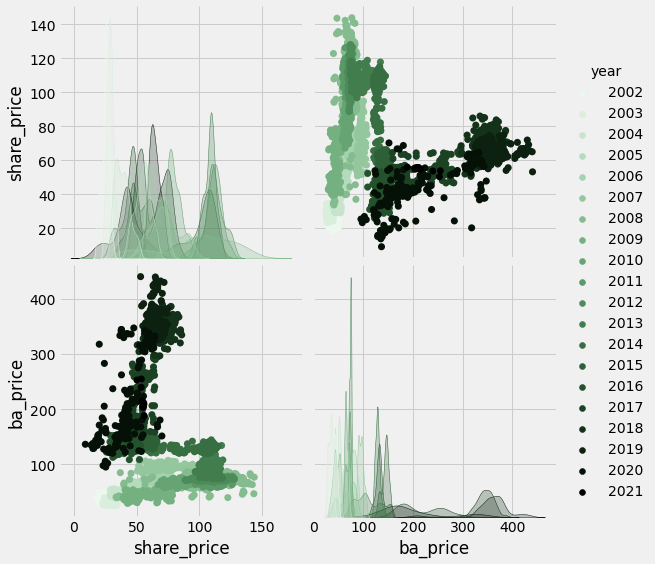

In [6]:
#==============================================================================
# Pairplot using last 20 years data with filtering on BrentOil share price
#==============================================================================
all_data12=all_data[all_data["year"]>2001]
palette=sns.cubehelix_palette(20, start=2, rot=0, dark=0, light=.95, reverse=False)

ccc = all_data12[all_data12['name']=="BrentOilPrices"].drop(["share_price_scaled"],axis=1)
ccc.head(-5)

sns.pairplot(all_data12[all_data12['name']=="BrentOilPrices"].drop(["share_price_scaled"],axis=1),
             hue="year",palette=palette,size=4,markers="o",
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))

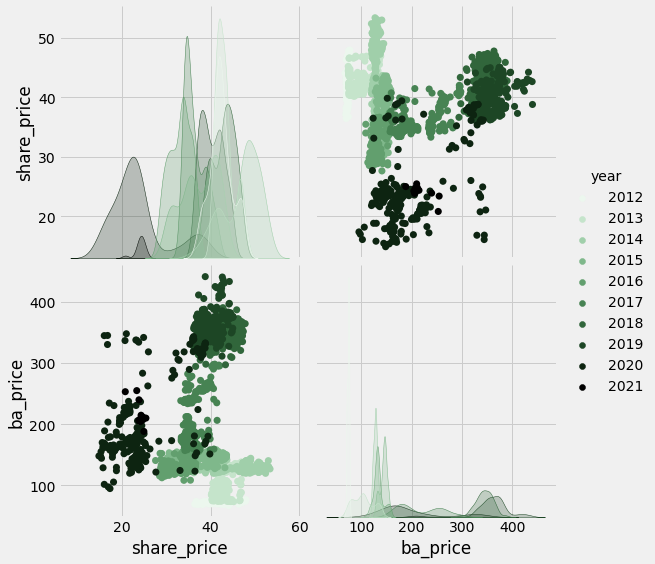

In [7]:
#==============================================================================
# Pairplot on less data (last 5 years) using BP stock price
#==============================================================================

# to change the size of dataset increase or decrease the year and next line palette year count
all_data13=all_data[all_data["year"]>2011]
palette=sns.cubehelix_palette(10, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data13[all_data13['name']=="BP"].drop(["share_price_scaled"],axis=1),
             hue="year",palette=palette,size=4,markers="o",
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))
#all_data13.head()

In [8]:
# Next we will construct a simple linear regression model using supervised 
# learning. The objective is to evaluate the prediction of data from the last 
# 100 days using data trained from years 2016/17 (excluding test data). 
# Train data is the data used to construct the model and test data is the data 
# we are trying to predict.

#==============================================================================
# Supervised learning linear regression
#==============================================================================

# all_data13 = 5/10 years see above worth of data

from sklearn import linear_model

# 1.- Data preparation
brentoil=pd.DataFrame()
brentoil=all_data13[(all_data13['name']=="BrentOilPrices") & (all_data13['year']>2019 )] # Extract data from years 2020/21 (2 years data)
brentoil=brentoil[["share_price","ba_price"]].reset_index()

# Just using 1 variable for linear regression. To try with more variables use randomforest
# Split the data into training/testing sets
train = brentoil[:-100]
test = brentoil[-100:]

x_train=train["share_price"].to_frame() #converts the pandas Series to numpy.ndarray
y_train=train["ba_price"].to_frame()
x_test=test["share_price"].to_frame() #converts the pandas Series to numpy.ndarray
y_test=test["ba_price"].to_frame()

# 2.- Create linear regression object
regr = linear_model.LinearRegression()

# 3.- Train the model using the training sets
regr.fit(x_train,y_train)

# The coefficients
print("Coefficients: ",  float(regr.coef_))
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_train) - y_train) ** 2))

Coefficients:  3.1470196930637275
Mean squared error: 3399.85


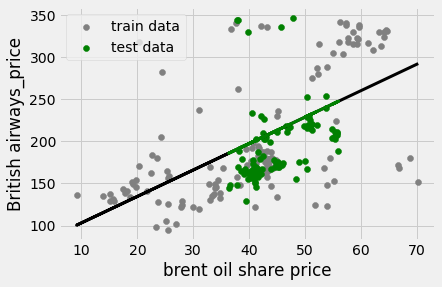

In [10]:
# Plot outputs using matplotlib
plt_train=plt.scatter(x_train, y_train,  color='grey')
plt_test=plt.scatter(x_test, y_test,  color='green')
plt.plot(x_train, regr.predict(x_train), color='black', linewidth=3)
plt.plot(x_test,regr.predict(x_test),  color='green', linewidth=3)
plt.xlabel("brent oil share price")
plt.ylabel("British airways_price")
plt.legend((plt_train, plt_test),("train data", "test data"))
plt.show()

In [11]:
# Load share price of other variables


from sklearn.ensemble import RandomForestRegressor
# 1.- Data Preparation
ba_df=pd.DataFrame()
ba_df=all_data13[(all_data13['year']>2015 )]
ba_df=ba_df[["date", "ba_price"]].reset_index()

ba_df = ba_df[-400:].reset_index() # adjust this between 1500 and 150 to limit or increase data

#all_data13.head(-5)

# Load share price of other variables
# aapl_df['BrentOilPrices']=all_data13[(all_data13['name']=="BrentOilPrices")][-373:].reset_index()['share_price']
#aapl_df['BP']=all_data13[(all_data13['name']=="BP")][-373:].reset_index()['share_price']

ba_df['BrentOilPrices']=all_data13[(all_data13['name']=="BrentOilPrices")].reset_index()['share_price']
ba_df['BP']=all_data13[(all_data13['name']=="BP")].reset_index()['share_price']

# aapl_df.dropna(3)
ba_df.head(-1)
train = ba_df[:-100]
test = ba_df[-100:]
# train.head(-1)

# aapl_df.head(-1)
x_train=train[["BrentOilPrices","BP"]]
y_train=train['ba_price']

x_test=test[["BrentOilPrices","BP"]] 
y_test=test['ba_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor = RandomForestRegressor(n_estimators=200, max_depth=5 )

# 3.- Train data
clf=regressor.fit(x_train, y_train)

# 4.- Predict!
y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)

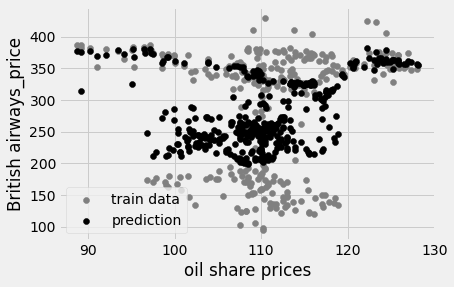

In [14]:
# We are going to have a look at how fitted data looks like:

x_train.head()
plt_train=plt.scatter(x_train["BrentOilPrices"],y_train,   color='grey')
plt_pred=plt.scatter(ba_df["BrentOilPrices"], regressor.predict(ba_df[["BrentOilPrices","BP"]]),  color='black')

plt.xlabel("oil share prices")
plt.ylabel("British airways_price")
plt.legend((plt_train,plt_pred),("train data","prediction"))
plt.show()


# This model predicts training data 
# There are many parameters to tune, but a key one is max depth. This will provide the depth of the

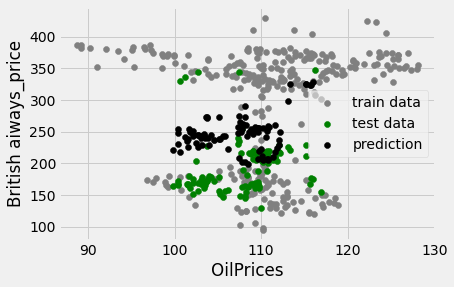

In [15]:
# predict test data now
plt_train=plt.scatter(x_train["BrentOilPrices"],y_train,   color='grey')
plt_test=plt.scatter(x_test["BrentOilPrices"],y_test,   color='green')
plt_pred=plt.scatter(x_test["BrentOilPrices"], y_pred,  color='black')

plt.xlabel("OilPrices")
plt.ylabel("British aiways_price")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

In [16]:
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

Mean squared error: 4250.04


Feature ranking:
Feature BrentOilPrices (0.436139)
Feature BP (0.563861)


Text(0, 0.5, 'Importance')

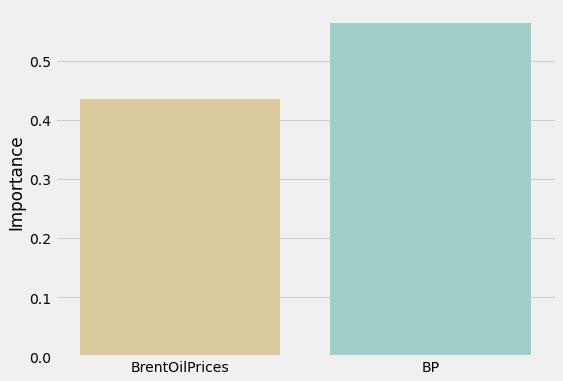

In [17]:
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")

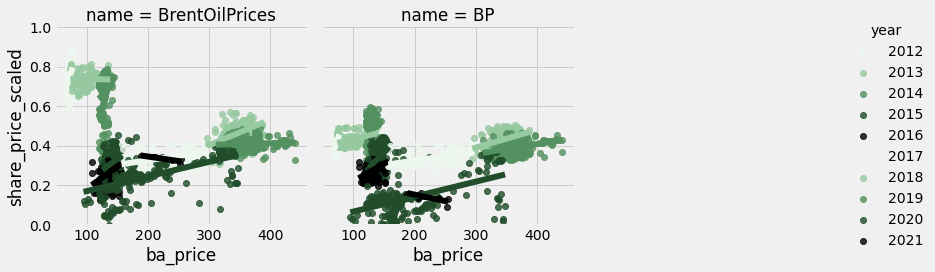

In [19]:
#We dont really see that much on that chart. Lets add different colors for each year and see if correlations are telling us anything.

palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.lmplot(x="ba_price", y="share_price_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=all_data13, order=1,palette=palette,size=4).set(ylim=(0, 1))

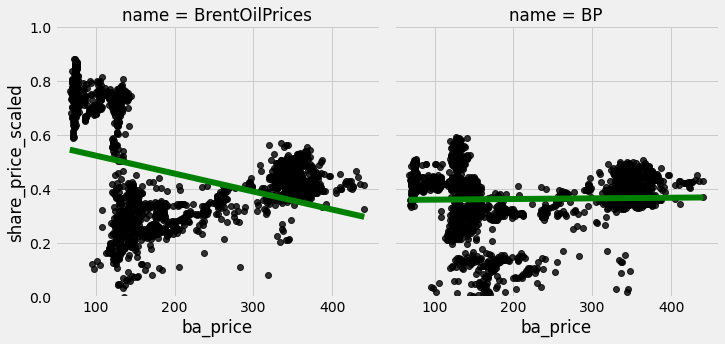

In [21]:
#Plot of oil price vs share price of different companies using different templates
#The next analysis will do a grid of charts for all companies to check if we see any patterns.
#==============================================================================
# lmplot using using 5 years for all companies
#==============================================================================

sns.lmplot(x="ba_price", y="share_price_scaled", col="name",ci=None, col_wrap=3, 
           data=all_data13, order=1,line_kws={'color': 'green'},scatter_kws={'color': 'black'}).set(ylim=(0, 1))